In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from gensim.models import Word2Vec
from scapy.all import PcapReader
from sklearn.feature_selection import f_classif, SelectKBest, RFE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from read_pcaps import pcap_to_dataframe

2024-02-19 19:42:07.704632: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 19:42:07.793101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 19:42:07.793169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 19:42:07.795402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 19:42:07.808557: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 19:42:10.616316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [2]:
# define a variable that allows you to read prior saved pkl files
READ_FROM_PKL = True

In [3]:
if READ_FROM_PKL:
    mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
    benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")
else:
    pcap_reader_mirai = PcapReader("../data/blog_eda/mirai.pcap")
    pcap_reader_benign = PcapReader("../data/blog_eda/benign.pcapng")
    mirai_df = pcap_to_dataframe(pcap_reader_mirai)
    benign_df = pcap_to_dataframe(pcap_reader_benign)

In [4]:
# read features saved, add new ones
if READ_FROM_PKL:
    mirai_features_df = pd.read_pickle("../data/blog_fe/mirai_features.pkl")
    benign_features_df = pd.read_pickle("../data/blog_fe/benign_features.pkl")
else:
    print(
        "Error! Feature pkl not saved. Please run blog_fe_2.ipynb, blog_fe_3.ipynb, blog_fe_4.ipynb or download from here: https://drive.google.com/drive/folders/1dBQhbQtIk_fbbb80G5pSVV3hbWYJY7fv?usp=sharing"
    )

In [5]:
# drop rows with None
mirai_df = mirai_df.dropna()
benign_df = benign_df.dropna()

# Add labels

In [6]:
# add labels, 0 for benign, 1 for malicious
mirai_features_df["Label"] = 1
benign_features_df["Label"] = 0

In [7]:
concatenated_df = pd.concat([mirai_features_df, benign_features_df], ignore_index=True)

In [8]:
shuffled_df = shuffle(concatenated_df, random_state=42)

In [9]:
# make sure that all features are numeric, otherwise feature selection will not work
shuffled_df.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Packet Length',
       'Protocol', 'incoming_traffic', 'outgoing_traffic', 'traffic_ratio',
       'cumulative_length', 'interarrival', 'log_interarrival',
       'Numeric Source IP', 'Numeric Destination IP', 'payload_proto_encoded',
       'ICMP', 'TCP', 'UDP', 'Telnet', 'IPv6_encapsulation', 'GRE', 'ESP',
       'AH', 'DNS', 'ICMPv6', 'OSPF', 'SCTP', 'UDPLite', 'NETBIOS-NS',
       'NETBIOS-DGM', 'NETBIOS-SSN', 'IMAP', 'SNMP', 'SNMP_trap', 'HTTPS',
       'Syslog', 'LDAPS', 'FTPS', 'IMAPS', 'POP3S', 'SOCKS_proxy',
       'length_risk', 'dst_port_freq_encoded', 'payload_embedding', 'Label'],
      dtype='object')

In [10]:
shuffled_df = shuffled_df.drop("payload_embedding", axis=1)
shuffled_df_values = shuffled_df.values.astype(np.float64)

# Find rows with infinite values
inf_rows = np.isinf(shuffled_df_values).any(axis=1)

# Remove rows with infinite values
shuffled_df = shuffled_df[~inf_rows]

In [11]:
# Find rows with infinite values
inf_rows = shuffled_df.index[np.isinf(shuffled_df).any(1)]

# Remove rows with infinite values
shuffled_df = shuffled_df.drop(inf_rows)

# Display the DataFrame after removing rows with infinite values
print("\nDataFrame after removing rows with infinite values:")
print(shuffled_df)


DataFrame after removing rows with infinite values:
           Timestamp  Source Port  Destination Port  Packet Length  Protocol  \
104819  1.540452e+09      33489.0              53.0           41.0      17.0   
171876           NaN          NaN               NaN            NaN       NaN   
50181   1.540449e+09       4259.0              53.0           38.0      17.0   
144342  1.540453e+09      21897.0              23.0           26.0       6.0   
201802           NaN          NaN               NaN            NaN       NaN   
...              ...          ...               ...            ...       ...   
119879  1.540452e+09         23.0           21897.0           26.0       6.0   
103694  1.540452e+09       2148.0              53.0           50.0      17.0   
131932  1.540453e+09      59081.0              53.0           48.0      17.0   
146867  1.540453e+09      21897.0              23.0           26.0       6.0   
121958  1.540452e+09      50861.0           10240.0           48.0 

/tmp/ipykernel_280999/458818108.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  inf_rows = shuffled_df.index[np.isinf(shuffled_df).any(1)]


In [12]:
shuffled_df = shuffled_df.dropna()

# Split data
- Train
- Test

In [13]:
# X should contain your feature columns, and y should contain the labels (0 or 1)
X = shuffled_df.drop(columns=["Label"], axis=1)
y = shuffled_df["Label"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Filter

In [14]:
import warnings
warnings.filterwarnings("ignore")  # This will suppress all warnings

# Select the top k features using SelectKBest and f_classif
k_best = 5  # You can adjust this value based on your dataset and requirements
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, y_train)

# Train a classifier using the selected features
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_selected, y_train)

# Transform the test set using the same feature selector
X_test_selected = selector.transform(X_test)

# Make predictions and evaluate the performance
y_pred = clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print(f"Selected {k_best} features using SelectKBest and f_classif.")
print(f"Accuracy on the test set: {accuracy}")

Selected 5 features using SelectKBest and f_classif.
Accuracy on the test set: 1.0


In [15]:
# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Get names of selected feature columns
selected_columns = X_train.columns[selected_indices]
selected_columns

Index(['Timestamp', 'Packet Length', 'outgoing_traffic', 'Numeric Source IP',
       'payload_proto_encoded'],
      dtype='object')

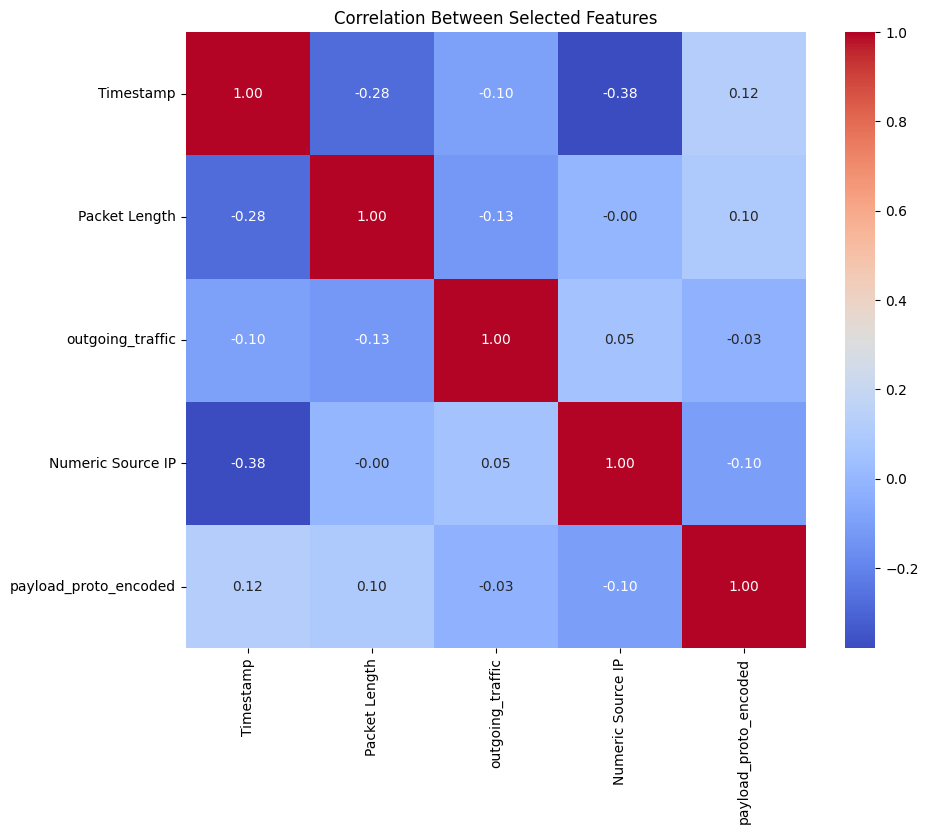

In [16]:
# Calculate the correlation matrix of the selected features
corr_matrix = np.corrcoef(X_train_selected, rowvar=False)

# Create a DataFrame for better visualization
columns = [f"{feature}" for feature in selected_columns]
corr_df = pd.DataFrame(corr_matrix, columns=columns, index=columns)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Selected Features")
plt.show()

# Wrapper

In [17]:
# Initialize a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE and specify the number of features to select
num_features_to_select = 5
rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected features:")
print(selected_features)

Selected features:
Index(['Timestamp', 'outgoing_traffic', 'Numeric Source IP',
       'Numeric Destination IP', 'payload_proto_encoded'],
      dtype='object')


In [18]:
# Train a classifier on the selected features
clf.fit(X_train[selected_features], y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test[selected_features])

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 1.00


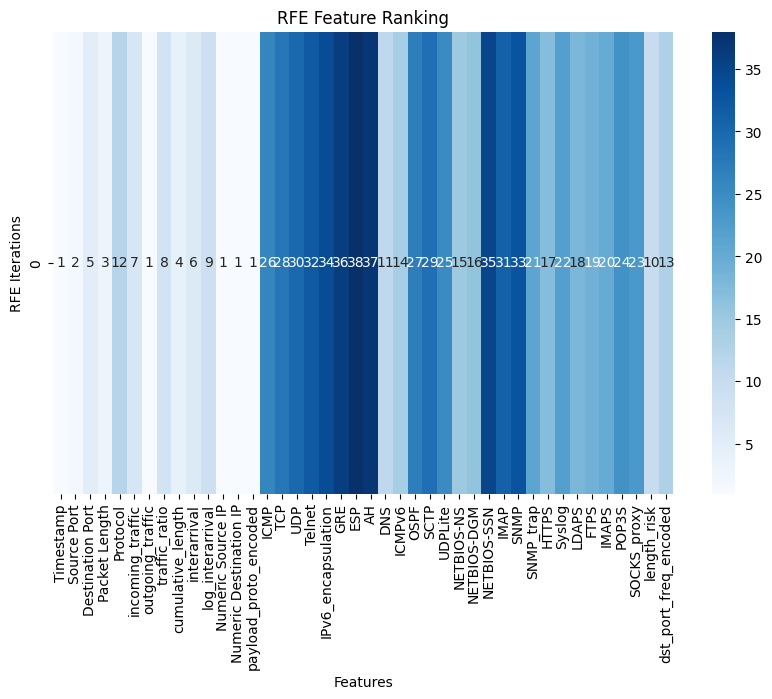

In [19]:
# Get the ranking of features
feature_ranking = rfe.ranking_

# Reshape the ranking array to match the original shape of features
num_features = len(X_train.columns)
ranking_matrix = np.reshape(feature_ranking, (-1, num_features))

# Create a heatmap to visualize the ranking
plt.figure(figsize=(10, 6))
sns.heatmap(
    ranking_matrix, cmap="Blues", annot=True, fmt="d", xticklabels=X_train.columns
)
plt.title("RFE Feature Ranking")
plt.xlabel("Features")
plt.ylabel("RFE Iterations")
plt.show()

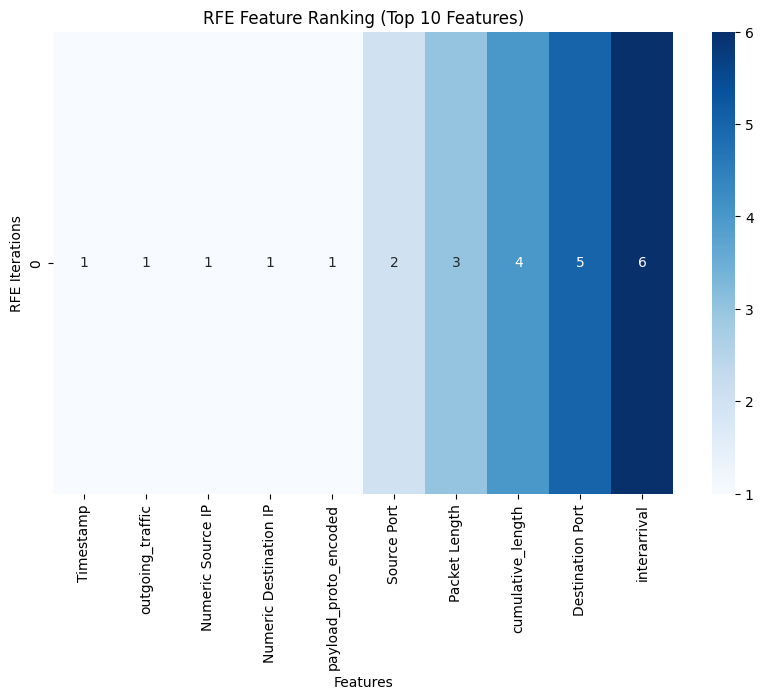

In [24]:
# Get the indices of the top 10 features
top_10_indices = np.argsort(feature_ranking)[:10]

# Extract the names of the top 10 features
top_10_features = X_train.columns[top_10_indices]

# Create a heatmap to visualize the ranking of top 10 features
plt.figure(figsize=(10, 6))
sns.heatmap(
    ranking_matrix[:, top_10_indices], cmap="Blues", annot=True, fmt="d", xticklabels=top_10_features
)
plt.title("RFE Feature Ranking (Top 10 Features)")
plt.xlabel("Features")
plt.ylabel("RFE Iterations")
plt.show()


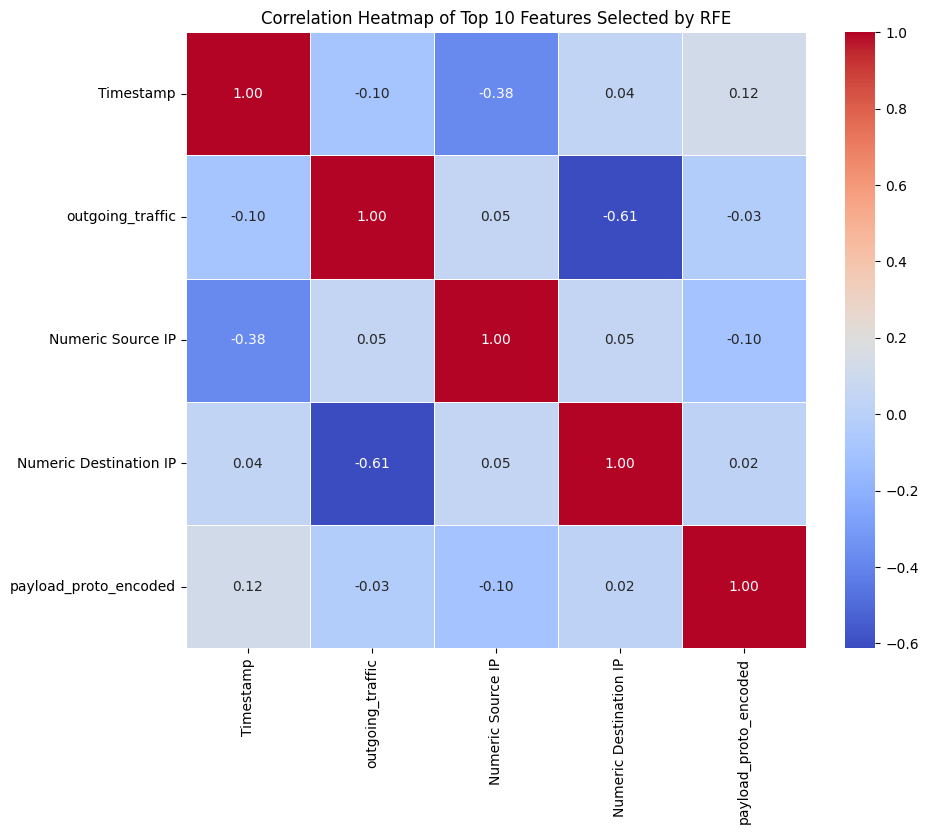

In [20]:
top_10_features = X_train.columns[rfe.support_]

# Create a heatmap of correlations between the top 10 features
plt.figure(figsize=(10, 8))
sns.heatmap(
    X_train[top_10_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Correlation Heatmap of Top 10 Features Selected by RFE")
plt.show()

# PCA

In [21]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA
n = 2
pca = PCA(n_components=n)  # Specify the number of components/features to keep
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a classifier (e.g., Random Forest) on the reduced feature space
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 1.00


In [22]:
# Get the absolute values of the loadings for each principal component
loadings = np.abs(pca.components_)

# Get the indices of the top N influential features for each principal component
n_top_features = 2  # Number of top features to print
top_feature_indices = np.argsort(-loadings, axis=1)[:, :n_top_features]

# Get the names of the top features
feature_names = X.columns
top_feature_names = [
    [feature_names[i] for i in indices] for indices in top_feature_indices
]

# Print the top N influential features for each principal component
for i in range(n):
    print(f"Principal Component {i+1}:")
    for j, feature_name in enumerate(top_feature_names[i]):
        print(f"    Feature {j+1}: {feature_name}")

Principal Component 1:
    Feature 1: dst_port_freq_encoded
    Feature 2: DNS
Principal Component 2:
    Feature 1: outgoing_traffic
    Feature 2: Numeric Destination IP


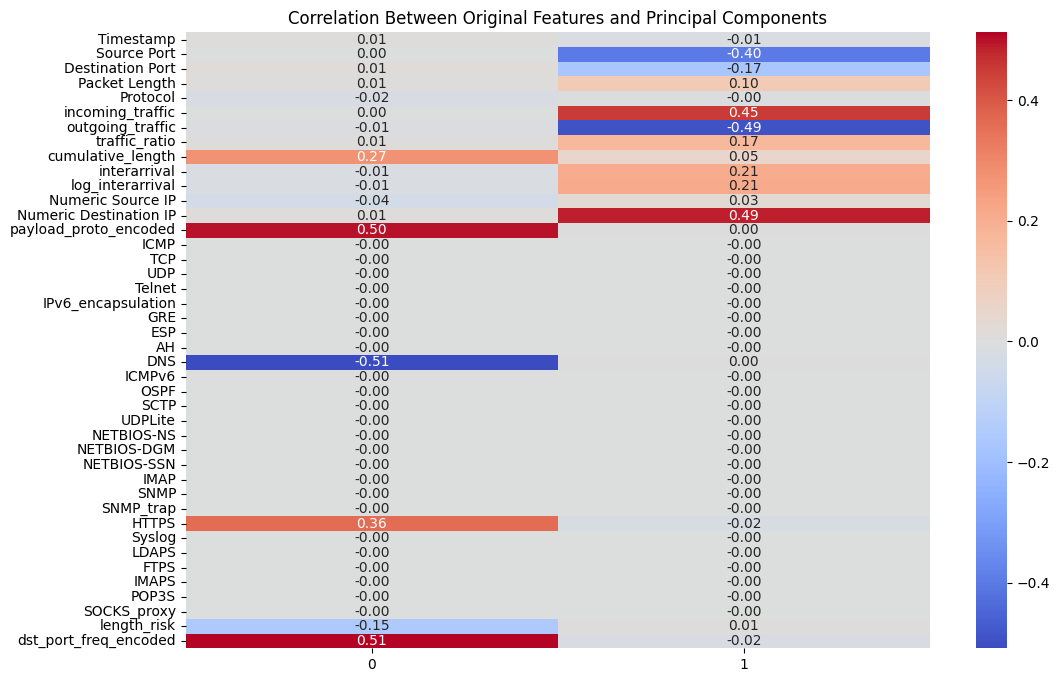

In [23]:
# Access the loadings of principal components
loadings = pca.components_

# Visualize correlation between original features and principal components
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(loadings, columns=X_train.columns).transpose(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between Original Features and Principal Components')
plt.show()